## 1. Loading data

### 1.1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import glob, os, json
import time

### 1.2. Loading the data

In [2]:
start_time = time.time()

places = []

# path to the directory where JSON files are stored
directory_path = "./data/"

for file in Path(directory_path).glob("*.json"): 

    with open(file) as json_file:
        data = json.load(json_file)

    for result in data:
        for place in result["places"]:
            place["date"] = file.stem 
            places.append(place)

df = pd.DataFrame(places)

print("--- %s seconds ---" % (time.time() - start_time))

--- 45.014769554138184 seconds ---


## 2. Preparing data for analysis

### 2.1. Data preprocessing

In [3]:
df.shape

(1478785, 16)

In [4]:
print(df.shape)
print(df.columns)

(1478785, 16)
Index(['uid', 'lat', 'lng', 'name', 'spot', 'number', 'bikes', 'bike_racks',
       'free_racks', 'terminal_type', 'bike_numbers', 'bike_types',
       'place_type', 'rack_locks', 'date', 'maintenance'],
      dtype='object')


In [5]:
df_ = df.drop(df.columns[[4, 5, 9, 11, 12, 13, 15]], axis = 1)

In [6]:
def data_preprocessing_1(df): 
    
    # split JSON file names into year, month, day, hour and minutes
    df_ = pd.DataFrame({'year': df['date'].str[0:4],
                     'month': df['date'].str[4:6],
                     'day': df['date'].str[6:8],
                     'hour': df['date'].str[9:11],
                     'minutes': df['date'].str[11:13]})
    df['date'] = pd.to_datetime(df_)  # add the column with the date from the above parts of JSON file names
    df['the_day_of_the_week'] = df['date'].dt.day_name() # add the column with the day of the week
    df['city_code'] = '352200375' # add the column with the station code for Warsaw
    df['date_normalize'] = df['date'] 
    # add the column with the date in the form Y-M-D
    df['date_normalize'] = pd.to_datetime(df['date_normalize']).dt.strftime('%Y-%m-%d') 
    
    return df


def data_preprocessing_2(df):
    
    # remove the data from 2018-04-02 (on this day the data is available only until 3:00)
    df = df[df.date_normalize != '2018-04-02'] 
    df['bikes'] = df['bikes'].replace('?', np.nan).astype(float)  # remove '?' from the 'bikes column'
    # convert the column with the number of stations to numerical values
    df['bike_racks'] = pd.to_numeric(df['bike_racks'])  
    return df
    

In [7]:
data = data_preprocessing_1(df_)
df = data_preprocessing_2(data)

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 2.2. Loading and joining meteorological data (temperature and total rainfall)

In [8]:
df_temp_march = pd.read_csv('additional_data/B00300S_2018_03.csv') # temperature values recorded for March 2018
df_temp_april = pd.read_csv('additional_data/B00300S_2018_04.csv') # temperature values recorded for April 2018

In [9]:
def temp_data_preprocessing(df_temp_march, df_temp_april):

    df_temp_march = df_temp_march.fillna(0) 
    df_temp_april = df_temp_april.fillna(0)

    temperature_march = df_temp_march.rename(columns={"249190890;B00300S;2018-03-01 00:00;-19": "temp1", 
                                                      "10;": "temp2"})
    temperature_april = df_temp_april.rename(columns={"249190890;B00300S;2018-04-01 00:00;7": "temp1",
                                                      "20;": "temp2"})

    temperature_df = pd.DataFrame(columns = ['city_code', 'date'])
    temperature_df['date'] = temperature_march['temp1'].str[18:34]
    temperature_df['city_code'] = temperature_march['temp1'].str[0:9]

    total_temp = pd.DataFrame(columns = ['city_code', 'date', 'temperature']) 
    total_temp['date'] = temperature_df['date'].append(temperature_april['temp1'].str[18:34], 
                         ignore_index = True)
    
    total_temp['city_code'] = temperature_df['city_code'].append(temperature_april['temp1'].str[0:9],
                              ignore_index = True)

    # extracts year, month, day, hour and minute from the dataframe
    cops = pd.DataFrame({'year': total_temp['date'].str[0:4],
                     'month': total_temp['date'].str[5:7],
                     'day': total_temp['date'].str[8:11],
                     'hour': total_temp['date'].str[11:13],
                     'minutes': total_temp['date'].str[14:17]})
    
    # creates the column with the date of temperature reading
    total_temp['date'] = pd.to_datetime(cops) 

    # converts the second column to str and extracts a decimal from it
    temperature_march['temp2'] = temperature_march['temp2'].astype(str).str[0]  
    temperature_april['temp2'] = temperature_april['temp2'].astype(str).str[0]

    # extracts from the first column the value of one or tens of temperatures
    temperature_march['temp1'] = temperature_march['temp1'].str[35:]
    temperature_march['temp1'] = temperature_march['temp1'].replace(';','', regex=True)

    temperature_april['temp1'] = temperature_april['temp1'].str[35:]
    temperature_april['temp1'] = temperature_april['temp1'].replace(';','', regex=True)

    # combines the tens, ones from the first column with a decimal from the second column
    new_temp1 = temperature_march['temp2'].copy()
    temperature_march['temp1'] = temperature_march['temp1'].str.cat(new_temp1, sep='.')
    temperature_march= temperature_march.drop(temperature_march.columns[[1]], axis=1)

    new_temp2 = temperature_april['temp2'].copy()
    temperature_april['temp1'] = temperature_april['temp1'].str.cat(new_temp2, sep='.')
    temperature_april= temperature_april.drop(temperature_april.columns[[1]], axis=1)

    temp_all = pd.concat([temperature_march, temperature_april])
    temp_all = temp_all.reset_index(drop=True) 
    total_temp['temperature'] = temp_all
    return total_temp

In [10]:
total_temp = temp_data_preprocessing(df_temp_march, df_temp_april)

df_ = pd.merge(df, total_temp, how='left', on=['date', 'city_code']) # append the temp data to the main dataframe
df_['temperature'] = pd.to_numeric(df_['temperature']) # change the data type of the column with temp values from str to int

In [11]:
rainfall_df = pd.read_excel('additional_data/rainfall_data_03_04.xlsx')

In [12]:
rainfall_df

,352200375,B00606S,godz,suma
0,352200375,B00606S,2018-03-04 00:00:00,0.0
1,352200375,B00606S,2018-03-04 01:00:00,0.0
2,352200375,B00606S,2018-03-04 02:00:00,0.0
3,352200375,B00606S,2018-03-04 03:00:00,0.0
4,352200375,B00606S,2018-03-04 04:00:00,0.0
...,...,...,...,...
691,352200375,B00606S,2018-04-01 19:00:00,0.0
692,352200375,B00606S,2018-04-01 20:00:00,0.0
693,352200375,B00606S,2018-04-01 21:00:00,0.0
694,352200375,B00606S,2018-04-01 22:00:00,0.1


In [13]:
rainfall_df = rainfall_df.drop(columns = [352200375, 'B00606S' ])
rainfall_df = rainfall_df.rename(columns={"godz": "date", "suma": "rainfall"})
rainfall_df['date'] = pd.to_datetime(rainfall_df['date'])

df = pd.merge(df_, rainfall_df, how='left', on=['date', 'date']) # append rainfall data to the main dataframe
df = df.fillna(0) # NaNs of 00:10, 00:20, 00:30 etc. have been replaced with zeros

main_df = df.copy()
main_df.set_index(['date', 'temperature', 'rainfall', 'name'], inplace=True)
main_df.sort_index(inplace=True)

In [14]:
main_df

uid  \
date                temperature rainfall name                                          
2018-03-04 00:00:00 -11.8       0.0      1 Sierpnia - DK Włochy              2585825   
                                         11 Listopada - Ratuszowa            2585972   
                                         11 listopada - Środkowa             2585974   
                                         Abrahama - Kapelanów AK             2586039   
                                         Afrykańska - Egipska                2586037   
...                                                                              ...   
2018-04-01 23:50:00  1.2        0.0      Żelazna - Chłodna                   2585401   
                                         Żelazna - Grzybowska                2585402   
                                         Żelazna - Sienna                    2585433   
                                         Żwirki i Wigury - Księcia Trojdena  2585772   
                                         Żwirki i Wigury - Racławicka        2585785   

                                                                                         lat  \
date                temperature rainfall name                                                  
2018-03-04 00:00:00 -11.8       0.0      1 Sierpnia - DK Włochy                   52.1946888   
                                         11 Listopada - Ratuszowa                  52.261449   
                                         11 listopada - Środkowa                   52.263109   
                                         Abrahama - Kapelanów AK                    52.22837   
                                         Afrykańska - Egipska                     52.2251969   
...                                                                                      ...   
2018-04-01 23:50:00  1.2        0.0      Żelazna - Chłodna                        52.2373141   
                                         Żelazna - Grzybowska                     52.2344946   
                                         Żelazna - Sienna                           52.22983   
                                         Żwirki i Wigury - Księcia Trojdena  52.205361371875   
                                         Żwirki i Wigury - Racławicka             52.1981365   

                                                                                         lng  \
date                temperature rainfall name                                                  
2018-03-04 00:00:00 -11.8       0.0      1 Sierpnia - DK Włochy                   20.9667823   
                                         11 Listopada - Ratuszowa                  21.037614   
                                         11 listopada - Środkowa                  21.0381895   
                                         Abrahama - Kapelanów AK                    21.08581   
                                         Afrykańska - Egipska                     21.0712892   
...                                                                                      ...   
2018-04-01 23:50:00  1.2        0.0      Żelazna - Chłodna                        20.9888488   
                                         Żelazna - Grzybowska                     20.9905117   
                                         Żelazna - Sienna                          20.993996   
                                         Żwirki i Wigury - Księcia Trojdena  20.984664559364   
                                         Żwirki i Wigury - Racławicka             20.9833717   

                                                                             bikes  \
date                temperature rainfall name                                        
2018-03-04 00:00:00 -11.8       0.0      1 Sierpnia - DK Włochy               11.0   
                                         11 Listopada - Ratuszowa             20.0   
                                         11 listopada - Środkowa              15.0   
        

### 2.2. Checking for missing values

In [15]:
warsaw_bikes_df_ = df.pivot_table(index=['date', 'temperature', 'rainfall'],
                     columns='name',
                     values='bikes')

In [16]:
nulls = pd.DataFrame(warsaw_bikes_df_.isnull().sum().sort_values(ascending = False).head(32), columns =['nulls']).reset_index(drop=False)


In [17]:
nulls['percent of nulls'] = round(nulls['nulls']/warsaw_bikes_df_.shape[0]*100)

In [18]:
nulls

,name,nulls,percent of nulls
0,Klarysew_test,4156,100.0
1,al. Jana Pawła II - ul. Anielewicza,4150,100.0
2,aps szczęśliwicka,4065,98.0
3,Marszałkowska - Złota,4062,98.0
4,Teststation IT - Adrian | FVT-4 Przed budynkiem,4042,97.0
5,PKN Orlen - Wydawnicza,4035,97.0
6,PKN Orlen - Bielańska,4035,97.0
7,PKN Orlen - Chodakowska,4035,97.0
8,PKN Orlen - E-bike Bielańska,4035,97.0
9,PKN Orlen - Migdałowa,4035,97.0


For the stations: 
- Czerniakowska - Gagarina, 
- Marszałkowska - al. Solidarności, 
- Wołoska-Odyńca, 
- al. Jana Pawła II - Grzybowska

The number of missing information on the number of bikes at stations has been replaced with values from previous time intervals, as they do not constitute a large share in the entire data set.

The rest of the stations from the list above were removed from the analysis due to the large amount of missing information.

In [19]:
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'al. Jana Pawła II - Grzybowska'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'al. Jana Pawła II - Grzybowska'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Wołoska - Odyńca'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Wołoska - Odyńca'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Marszałkowska - al. Solidarności'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Marszałkowska - al. Solidarności'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Czerniakowska - Gagarina'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Czerniakowska - Gagarina'].fillna(method = 'ffill')

In [20]:
warsaw_bikes_df_ = warsaw_bikes_df_.transpose()
warsaw_bikes_df_ = warsaw_bikes_df_.dropna() # removes stations for which there is insufficient information
warsaw_bikes_df_ = warsaw_bikes_df_.transpose()

In [21]:
warsaw_bikes_df_.isnull().sum().sort_values(ascending = False).head(5)

name
1 Sierpnia - DK Włochy                    0
Radzymińska - Wiosenna                    0
Rembielińska - Kondratowicza              0
Rechniewskiego - Nowaka-Jeziorańskiego    0
Ratuszowa - ZOO                           0
dtype: int64

In [22]:
warsaw_bikes_data = warsaw_bikes_df_.diff()
warsaw_bikes_data = warsaw_bikes_data.iloc[1:, :]

In [23]:
# Number of bike rentals is an absolute value from the difference in the number of bikes at the station between the following lines (time intervals)
warsaw_bikes_rent = warsaw_bikes_data.copy()
warsaw_bikes_rent[warsaw_bikes_rent > 0] = 0 # do not take into account the arrival of the bike at the stations
warsaw_bikes_rent[warsaw_bikes_rent < 0] = abs(warsaw_bikes_rent) 
warsaw_bikes_rent = warsaw_bikes_rent.transpose()


In [24]:
warsaw_bikes_rent = warsaw_bikes_rent.unstack().rename('bike_rental').reset_index()

In [25]:
warsaw_bikes_rent['the_day_of_the_week'] = warsaw_bikes_rent.date.dt.day_name() # create the column with the day of the week
warsaw_bikes_rent['date_'] = warsaw_bikes_rent.date.dt.date # create the date column in the form Y-M-D
warsaw_bikes_rent['hour_'] = warsaw_bikes_rent.date.dt.hour # create the column with an hour

### 2.3. Checking outliers

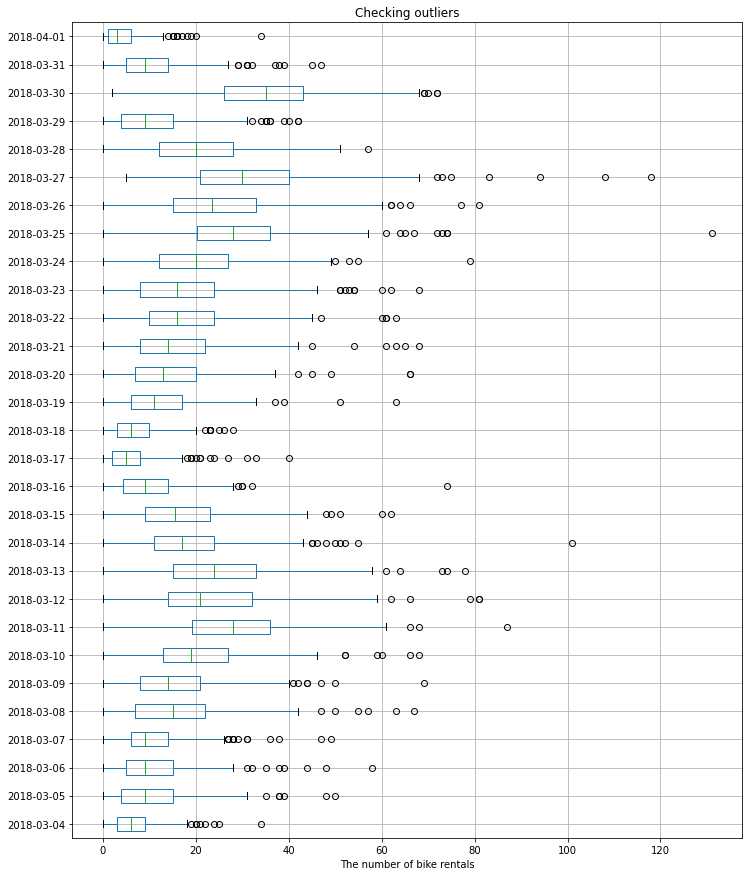

In [26]:
# checking outliers for individual days
outpoints_day = warsaw_bikes_rent.pivot_table(index='name', columns=['date_'], values='bike_rental', aggfunc='sum')
outpoints_day.boxplot(vert=False, figsize=(12,15)).set(title = "Checking outliers", xlabel = "The number of bike rentals")
plt.savefig('fig_1.png', dpi=800)
plt.show()

On the chart above, it can be seen that one station on 14 and 25 March recorded a much larger number of bike rentals compared to all other stations on that day.


Due to the large variety of locations of bike stations and the fact that they can be very popular in the event of major sports or music events, these values do not have to mean a data collection error. The popularity of the station was assessed on the basis of the median, which is not sensitive to outliers, so extreme points were not removed.

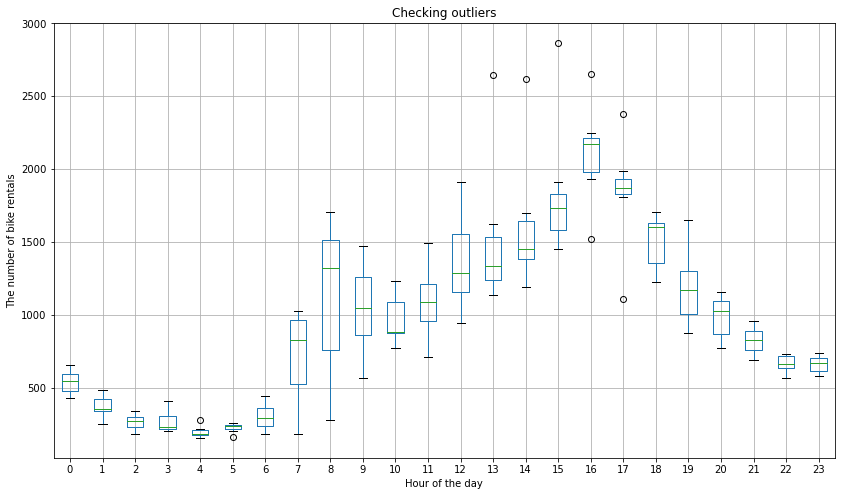

In [55]:
# box-plot for checking outliers in individual hours
outpoints_hour_day = warsaw_bikes_rent.pivot_table(index='the_day_of_the_week', 
                     columns=warsaw_bikes_rent['hour_'], 
                     values='bike_rental', 
                     aggfunc='sum').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of the day", ylabel = "The number of bike rentals")
plt.savefig('fig_2.png', dpi=800)

Analyzing the data in terms of the largest number of bikes rented from all time periods, it can be seen that for many stations on 27 March at 2:30 and 14 March at 7:00 there were above-average numbers of bikes rented. 

In [28]:
# checking on which days and hours there were the most bikes rentals
warsaw_bikes_rent['_date'] = pd.to_datetime(warsaw_bikes_rent['date'].dt.strftime('%Y-%m-%d %H'))
warsaw_bikes_rent['minutes_'] = warsaw_bikes_rent.date.dt.minute
hour_df = warsaw_bikes_rent.set_index('name').groupby([ 'name', '_date', 'minutes_', 'the_day_of_the_week']).agg({'bike_rental':np.sum})
hour_df.sort_values(by = ['bike_rental'], ascending = False).head(40) 

,,,,bike_rental
name,_date,minutes_,the_day_of_the_week,
Belwederska - Gagarina,2018-03-27 02:00:00,30,Tuesday,54.0
Arkadia,2018-03-27 02:00:00,30,Tuesday,49.0
Czerniakowska - Gagarina,2018-03-27 02:00:00,30,Tuesday,45.0
Dwernickiego - Siennicka,2018-03-27 02:00:00,30,Tuesday,43.0
Sadyba Best Mall,2018-03-27 02:00:00,30,Tuesday,42.0
Bulwar – most Śląsko – Dąbrowski,2018-03-26 00:00:00,10,Monday,37.0
Myśliwiecka - Rozbrat,2018-03-06 18:00:00,40,Tuesday,35.0
Arkadia,2018-03-27 16:00:00,50,Tuesday,35.0
Atrium Targówek,2018-03-27 02:00:00,30,Tuesday,34.0


In [29]:
# removes information about the number of bikes at stations from 03-27 2:30, 2:40 and 03-30 7:00
warsaw_bikes_rent = warsaw_bikes_rent[warsaw_bikes_rent.date != '2018-03-27 02:30:00'] 
warsaw_bikes_rent = warsaw_bikes_rent[warsaw_bikes_rent.date != '2018-03-27 02:40:00']
warsaw_bikes_rent = warsaw_bikes_rent[warsaw_bikes_rent.date != '2018-03-30 07:00:00']

# sums up the number of bike rentals for stations on individual days
bikes_df = warsaw_bikes_rent.set_index('name').groupby([ 'name', 'date_']).agg({'temperature':np.mean, 'rainfall':np.sum, 'bike_rental':np.sum})

bikes_df['temperature'] = bikes_df['temperature'].round(1) # round temp values
bikes_df['rainfall'] = bikes_df['rainfall'].round(1) # round rainfall values

# creates the frame with the number of bikes rented on the particular day
df_ac = bikes_df.pivot_table(index='name', columns=['date_', 'temperature', 'rainfall'], values='bike_rental')

# determines the sum and average of bikes rented for individual stations
alldfc_ = df_ac.copy()
alldfc_['total_bike_rentals'] = alldfc_.sum(axis = 1)
#alldfc_['average rented'] = alldfc_.mean(axis = 1)
bike_rentals_total = alldfc_.sort_values('total_bike_rentals', ascending = False).reset_index()

After adding up the number of bikes rented at all stations throughout the data collection period, it can be seen that there are stations from which no bike was rented in the considered time. These stations, in the context of the popularity rating, were not taken into account and were deleted from the collection.

In [30]:
bike_rentals_total

date_,name,2018-03-04,2018-03-05,2018-03-06,2018-03-07,2018-03-08,2018-03-09,2018-03-10,2018-03-11,2018-03-12,...,2018-03-24,2018-03-25,2018-03-26,2018-03-27,2018-03-28,2018-03-29,2018-03-30,2018-03-31,2018-04-01,total_bike_rentals
temperature,,-6.7,-1.6,1.3,2.1,4.7,3.6,4.7,9.4,10.4,...,3.2,4.2,4.5,1.6,1.8,2.4,6.4,6.7,5.0,
rainfall,,0.0,0.0,0.8,0.2,0.0,0.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,5.5,0.0,4.4,4.3,
0,al. Niepodległości - Batorego,17.0,50.0,58.0,31.0,57.0,69.0,60.0,51.0,45.0,...,79.0,45.0,44.0,67.0,49.0,39.0,45.0,7.0,9.0,1368.0
1,Stefana Banacha - UW,7.0,48.0,44.0,47.0,63.0,47.0,42.0,39.0,54.0,...,31.0,50.0,64.0,51.0,51.0,28.0,42.0,16.0,7.0,1242.0
2,Plac Wileński,14.0,15.0,28.0,49.0,25.0,38.0,68.0,68.0,38.0,...,55.0,73.0,55.0,51.0,38.0,42.0,46.0,38.0,34.0,1240.0
3,Rondo Jazdy Polskiej,19.0,38.0,35.0,28.0,67.0,42.0,33.0,52.0,53.0,...,33.0,54.0,57.0,49.0,47.0,36.0,54.0,15.0,4.0,1160.0
4,Emilii Plater - Al. Jerozolimskie,20.0,27.0,38.0,25.0,36.0,29.0,38.0,49.0,46.0,...,42.0,42.0,54.0,40.0,29.0,24.0,54.0,16.0,12.0,1009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,CH Marywilska 44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,17.0
346,Grapa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [31]:
# removes from the dataframe the stations for which rentals values are unreliable
bikes_df = bikes_df.drop(['Mirków', 'Klarysew', 'Park Zdrojowy', 'Grapa', 'CH Marywilska 44', 'Skolimów'])

## 3. Exploratory data analysis

### 3.1. Analysis of popularity of bike routes

In [33]:
start_time = time.time()
bike_routes = (df.set_index(['name', 'date', 'uid', 'lat', 'lng'])
            ['bike_numbers'].str.split(',', expand=True)
            .stack()
            .reset_index(name='bike_numbers')
            .drop('level_5',1))

print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


--- 344.3000919818878 seconds ---


In [34]:
bike_routes['bike_numbers'] = bike_routes['bike_numbers'].replace('?', np.nan) 
bike_routes.dropna(subset=['bike_numbers'], inplace=True)

In [35]:
start_time = time.time()
bike_routes_df = bike_routes.pivot_table(index='date',
                                     columns=['bike_numbers'], 
                                     values='name',
                                     aggfunc=lambda x: ' '.join(x))

print("--- %s seconds ---" % (time.time() - start_time))

--- 318.46330404281616 seconds ---


In [36]:
bike_routes

,name,date,uid,lat,lng,bike_numbers
0,Dewajtis - UKSW,2018-03-04 00:00:00,2585259,52.296298,20.9583575,24731
1,Dewajtis - UKSW,2018-03-04 00:00:00,2585259,52.296298,20.9583575,24673
2,Dewajtis - UKSW,2018-03-04 00:00:00,2585259,52.296298,20.9583575,24612
3,Dewajtis - UKSW,2018-03-04 00:00:00,2585259,52.296298,20.9583575,26774
4,Dewajtis - UKSW,2018-03-04 00:00:00,2585259,52.296298,20.9583575,26632
...,...,...,...,...,...,...
19783740,Mirków,2018-04-01 23:50:00,3006012,52.097865383129,21.134390830994,60860
19783741,Mirków,2018-04-01 23:50:00,3006012,52.097865383129,21.134390830994,60859
19783742,Mirków,2018-04-01 23:50:00,3006012,52.097865383129,21.134390830994,60856
19783743,Mirków,2018-04-01 23:50:00,3006012,52.097865383129,21.134390830994,60847


In [37]:
bike_routes = bike_routes.rename(columns={"bike_numbers": "bike_number","name": "station_A", "date": "start_time", "lat": "lat_station_A", "lng": "lng_station_A", "uid": "ID_station_A"})
bike_routes = bike_routes.sort_values(['bike_number', 'start_time'], ascending=[True, True])

bike_routes['end_time'] = bike_routes.iloc[0:, 1]
bike_routes['end_time'] = bike_routes['end_time'].shift(-1)
bike_routes['station_B'] = bike_routes.iloc[0:, 0] 
bike_routes['station_B'] = bike_routes['station_B'].shift(-1)
bike_routes['ID_station_B'] = bike_routes.iloc[0:, 2] 
bike_routes['ID_station_B'] = bike_routes['ID_station_B'].shift(-1)
bike_routes['lat_station_B'] = bike_routes.iloc[0:, 3] 
bike_routes['lat_station_B'] = bike_routes['lat_station_B'].shift(-1)
bike_routes['lng_station_B'] = bike_routes.iloc[0:, 4] 
bike_routes['lng_station_B'] = bike_routes['lng_station_B'].shift(-1)

bike_routes = bike_routes[bike_routes['station_A'] != bike_routes['station_B']] # delete samples that contain the same stations
bike_routes = bike_routes.reset_index(drop = True)

bike_routes = bike_routes[['ID_station_A', 'lat_station_A', 'lng_station_A', 'station_A', 'start_time', 'bike_number', 'end_time', 'station_B', 'ID_station_B', 'lat_station_B', 'lng_station_B']]

bike_routes['lat_station_A'] = pd.to_numeric(bike_routes['lat_station_A'])
bike_routes['lng_station_A'] = pd.to_numeric(bike_routes['lng_station_A'])
bike_routes['lat_station_B'] = pd.to_numeric(bike_routes['lat_station_B'])
bike_routes['lng_station_B'] = pd.to_numeric(bike_routes['lng_station_B'])

The list of routes can be determined by sorting the dataframe by bike numbers and time, and then copying columns from the station data and moving one row up

In [38]:
routes = bike_routes.groupby(['ID_station_A', 'lat_station_A', 'lng_station_A', 'station_A', 'station_B', 'lat_station_B', 'lng_station_B', 'ID_station_B',]).size().reset_index(name='count')

In [39]:
regular_routes_ = routes.sort_values(by=['count'], na_position = 'first', ascending=False).reset_index(drop = True).head(400)

In [40]:
# pip install folium
import folium
from folium.plugins import MarkerCluster

In [41]:
rr_map = folium.Map(location=[52.24, 21.00],
    zoom_start=14,)



for ind in regular_routes_.index:     
    tooltip_txt = regular_routes_['station_A'][ind]
    tooltip_txt_ = regular_routes_['station_B'][ind]
     
       
    
    route_lats_longs = [[float(regular_routes_['lat_station_A'][ind]), float(regular_routes_['lng_station_A'][ind])],
                        [float(regular_routes_['lat_station_B'][ind]), float(regular_routes_['lng_station_B'][ind])]]
                        
    
    folium.PolyLine(route_lats_longs).add_to(rr_map)
    
rr_map

### 3.2. Exploration of patterns of bike routes using clustering algorithm

In [42]:
from community import community_louvain # pip install python_louvain 
import networkx as nx

In [43]:
G = nx.from_pandas_edgelist(regular_routes_, source='station_A', target='station_B', edge_attr=['count'])

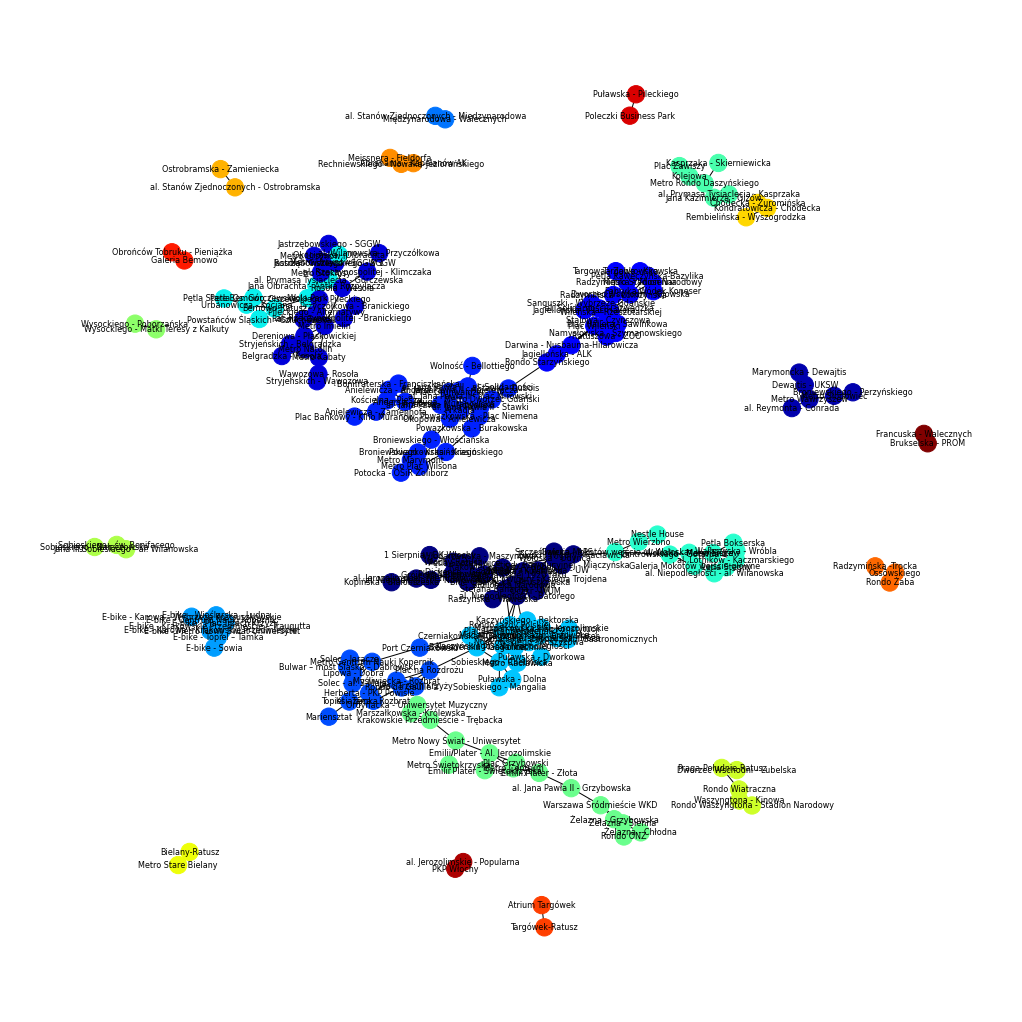

In [44]:
nx.transitivity(G)
part = community_louvain.best_partition(G)
mod = community_louvain.modularity(part,G)
plt.figure(figsize=(14, 14))
values = [part.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=300, with_labels=True, font_size = 8)
plt.show()

In [45]:
for k, v in part.items():
    if v == 3:   #displays the stations in the third cluster
        print(k)

Plac Hallera - Sawinkowa
Plac Wileński
Jagiellońska - Plac Hallera
Pętla Kawęczyńska-Bazylika
Dworzec Wschodni - Kijowska
Sanguszki - Wybrzeże Gdańskie
Radzymińska - Łomżyńska
Darwina - Nusbauma-Hilarowicza
Rondo Starzyńskiego
al. Solidarności - Szwedzka
Wileńska - Rzeszotarskiej
Radzymińska - Wiosenna
Metro Stadion Narodowy
Targowa - Ząbkowska
Namysłowska - Szymanowskiego
Stalowa - Czynszowa
Targowa - Kijowska
Ratuszowa - ZOO
Jagiellońska - ALK
Fabryka Wódek Koneser


In [46]:
routes['log_count'] = np.log10(routes['count'])  # the number of passes is logarithmized to make the heatmap clearer

In [47]:
id_routes = routes.pivot_table(index='ID_station_A', columns=['ID_station_B'], values='log_count')

In [48]:
import seaborn as sns

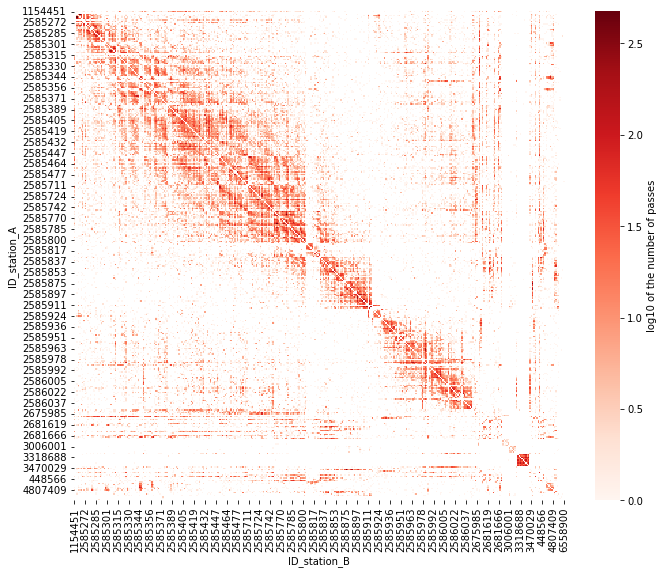

In [54]:
plt.figure(figsize=(11, 9))
sns.heatmap(id_routes, cmap="Reds", cbar_kws={'label': 'log10 of the number of passes'})
plt.savefig('heatmap.png', dpi=800)
plt.show()

In [50]:
popular_routes_ = bike_routes.groupby(['lat_station_A', 'lng_station_A', 'station_A', 'station_B', 'lat_station_B', 'lng_station_B',]).size().reset_index(name='count')
popular_routes_ = popular_routes_.sort_values(by=['count'], na_position = 'first', ascending=False).reset_index(drop = True).head(15)

In [51]:
popular_routes_  #15 of the most popular routes

,lat_station_A,lng_station_A,station_A,station_B,lat_station_B,lng_station_B,count
0,52.210772,20.984756,Stefana Banacha - UW,al. Niepodległości - Batorego,52.209916,21.006779,476
1,52.296298,20.958358,Dewajtis - UKSW,Marymoncka - Dewajtis,52.290173,20.950370,456
2,52.290173,20.950370,Marymoncka - Dewajtis,Dewajtis - UKSW,52.296298,20.958358,446
3,52.209916,21.006779,al. Niepodległości - Batorego,Stefana Banacha - UW,52.210772,20.984756,445
4,52.162258,21.028076,Metro Ursynów I,Jastrzębowskiego - SGGW 1,52.162383,21.038411,386
5,52.162383,21.038411,Jastrzębowskiego - SGGW 1,Metro Ursynów I,52.162258,21.028076,366
6,52.142720,21.038362,Pileckiego - Alternatywy,Metro Imielin,52.149310,21.045336,245
7,52.137604,21.050553,Stryjeńskich - Belgradzka,Metro Natolin,52.140391,21.056819,234
8,52.131093,21.065479,Metro Kabaty,Stryjeńskich - Wąwozowa,52.131433,21.056156,219
9,52.261381,21.030544,Plac Hallera - Sawinkowa,Plac Wileński,52.254976,21.033901,219


In [52]:
pp_map = folium.Map(location=[52.24, 21.00],
    zoom_start=14,)



for ind in popular_routes_.index:     
    tooltip_txt = popular_routes_['station_A'][ind]
    tooltip_txt_ = popular_routes_['station_B'][ind]
     
    
    folium.Marker([float(popular_routes_['lat_station_A'][ind]), float(popular_routes_['lng_station_A'][ind])],
                 icon=folium.Icon(color='red'),
                tooltip= tooltip_txt).add_to(pp_map)
    
    folium.Marker([float(popular_routes_['lat_station_B'][ind]), float(popular_routes_['lng_station_B'][ind])],
                 icon=folium.Icon(color='red'),
                tooltip= tooltip_txt_).add_to(pp_map)
    
    
    route_lats_longs = [[float(popular_routes_['lat_station_A'][ind]), float(popular_routes_['lng_station_A'][ind])],
                        [float(popular_routes_['lat_station_B'][ind]), float(popular_routes_['lng_station_B'][ind])]]
                        
    
    folium.PolyLine(route_lats_longs).add_to(pp_map)
    
pp_map

### 3.3. Analysis of the length of bike rentals

In [55]:
bike_routes['time_diff'] = abs(bike_routes['end_time'] - bike_routes['start_time'])
bike_routes['total_minutes'] = bike_routes['time_diff'].dt.total_seconds()/ 60
bike_routes['total_minutes'] = bike_routes['total_minutes'].loc[bike_routes['total_minutes'] <90]

C:\Users\Przem\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


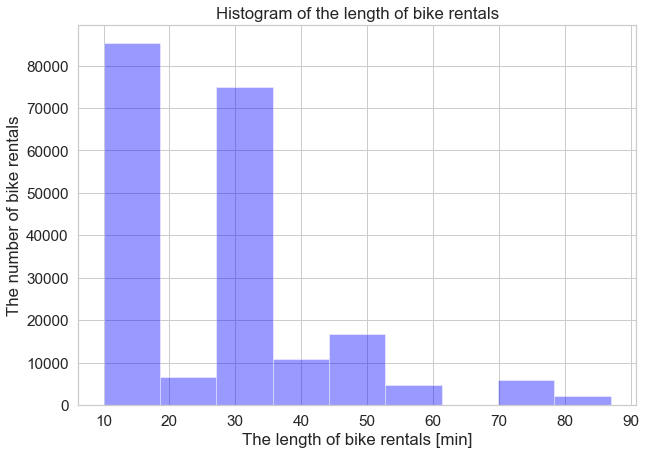

In [56]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.distplot(bike_routes['total_minutes'], kde = False, bins = 9, color = 'blue').set(title = 'Histogram of the length of bike rentals', xlabel = 'The length of bike rentals [min]', ylabel = 'The number of bike rentals')
plt.savefig('hist_of_length_of_bike_rentals_.png', dpi=800)
plt.show()

In [57]:
bike_routes

,ID_station_A,lat_station_A,lng_station_A,station_A,start_time,bike_number,end_time,station_B,ID_station_B,lat_station_B,lng_station_B,time_diff,total_minutes
0,2585370,52.244267,21.001589,Marszałkowska - al. Solidarności,2018-03-04 16:20:00,24001,2018-03-04 16:50:00,Senatorska - Bielańska,2585373,52.243572,21.006680,0 days 00:30:00,30.0
1,2585373,52.243572,21.006680,Senatorska - Bielańska,2018-03-06 10:50:00,24001,2018-03-06 16:30:00,Krakowskie Przedmieście - Trębacka,2585378,52.243597,21.014080,0 days 05:40:00,NaN
2,2585378,52.243597,21.014080,Krakowskie Przedmieście - Trębacka,2018-03-06 19:50:00,24001,2018-03-06 20:00:00,Marszałkowska - Królewska,2585416,52.238485,21.006755,0 days 00:10:00,10.0
3,2585416,52.238485,21.006755,Marszałkowska - Królewska,2018-03-07 23:30:00,24001,2018-03-08 00:00:00,Rondo ONZ,2585408,52.232628,20.997123,0 days 00:30:00,30.0
4,2585408,52.232628,20.997123,Rondo ONZ,2018-03-08 22:30:00,24001,2018-03-08 23:40:00,Dickensa - Geodetów,2585771,52.206154,20.970288,0 days 01:10:00,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227428,2585412,52.233631,21.002879,Emilii Plater - Świętokrzyska,2018-03-30 12:10:00,96592,2018-03-30 12:40:00,Plac na Rozdrożu,2585738,52.220021,21.025630,0 days 00:30:00,30.0
227429,2585738,52.220021,21.025630,Plac na Rozdrożu,2018-03-30 12:50:00,96592,2018-03-30 13:40:00,Topiel - Tamka,2585450,52.237593,21.025649,0 days 00:50:00,50.0
227430,2585450,52.237593,21.025649,Topiel - Tamka,2018-03-30 18:30:00,96592,2018-03-30 18:50:00,Herberta - PKP Powiśle,2585699,52.234019,21.030033,0 days 00:20:00,20.0
227431,2585699,52.234019,21.030033,Herberta - PKP Powiśle,2018-04-01 23:50:00,96592,2018-03-27 12:50:00,Klarysew_test,6558900,52.102973,21.114907,5 days 11:00:00,NaN


In [58]:
bike_routes['the_day_of_the_week'] = bike_routes['end_time'].dt.day_name() 
bike_routes['hour_'] = bike_routes['end_time'].dt.hour
bike_routes['_date'] = pd.to_datetime(bike_routes['end_time'].dt.strftime('%Y-%m-%d-%H'))

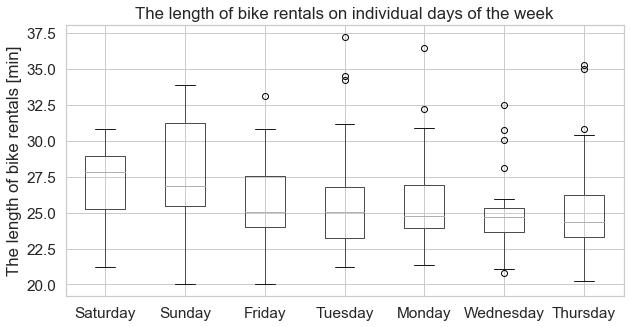

In [59]:
df_time_ = bike_routes.pivot_table(index=bike_routes['hour_'], 
                     columns='the_day_of_the_week', 
                     values='total_minutes')
df_time_ = df_time_.reset_index().rename_axis(None, axis=1)
df_time_  = df_time_.iloc[:, 1:]
meds_ =df_time_.median().sort_values(ascending=False)
df_time_  = df_time_[meds_.index]
df_time_.boxplot(figsize=(10,5)).set(title = "The length of bike rentals on individual days of the week", ylabel = "The length of bike rentals [min]")
plt.show()

### 3.2. Analysis of changes in temperature and rainfall

In [60]:
temp_df = df.groupby(['date_normalize']).agg({'temperature':np.mean})  # calculation of the average air temperature for each day
temp_df = temp_df.reset_index() 

rainfall_df['date_normalize'] = rainfall_df.date.dt.date
rain_df = rainfall_df.groupby(['date_normalize']).agg({'rainfall':np.sum}) # calculation of the total rainfall for each day
rain_df = rain_df.reset_index()

rain_temp_df = pd.concat([temp_df, rain_df['rainfall']], axis = 1)  # combine temperature values with the amount of rainfall

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


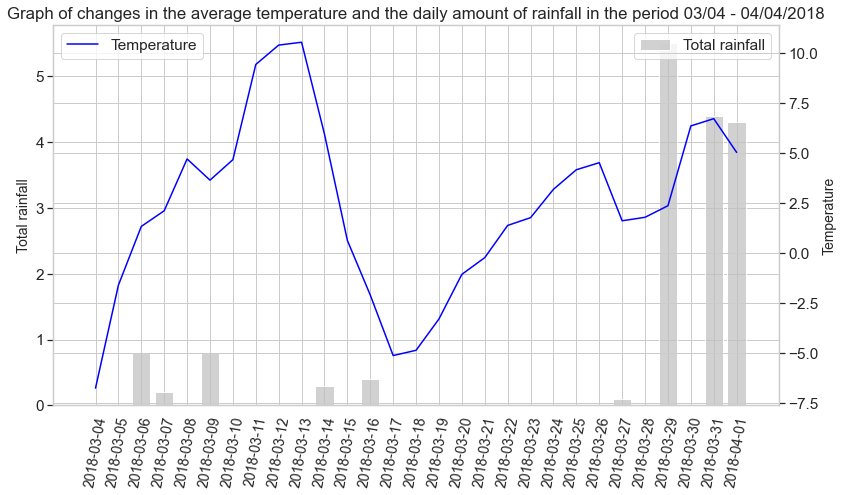

In [61]:
fig, ax = plt.subplots(figsize=(13,7))
ax2 = ax.twinx()
ax.bar(rain_temp_df["date_normalize"], rain_temp_df["rainfall"], color=(190/255,190/255,190/255,0.7), label='Total rainfall')
ax2.plot(rain_temp_df["date_normalize"], rain_temp_df["temperature"], color='blue', label='Temperature')
ax.set_xticklabels(rain_temp_df["date_normalize"][::1], rotation=80, fontsize='14')
ax.set_ylabel("Total rainfall", fontsize='14')
ax2.set_ylabel("Temperature", fontsize='14')
ax2.set_title("Graph of changes in the average temperature and the daily amount of rainfall in the period 03/04 - 04/04/2018")
ax.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

### 3.3. Analysis of bike stations

In [62]:
df['date_'] = df.date.dt.date
bikes_station_df = df.pivot_table(index='date_', columns=['name', 'lat', 'lng'], values='bike_racks')

In [117]:
bikes_station_df = bikes_station_df.fillna(method='ffill') # replace NaNs with the value noted in the previous period
bikes_station_df_ = pd.DataFrame(bikes_station_df.iloc[28, :]).reset_index() # data from the last day are collected to analyze the size of the stations
bikes_station_df_ = bikes_station_df_.rename(columns={bikes_station_df_.columns[3]: "bike_racks"})
bikes_station_df_['bike_racks'] = bikes_station_df_['bike_racks'].astype(int)

C:\Users\Przem\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


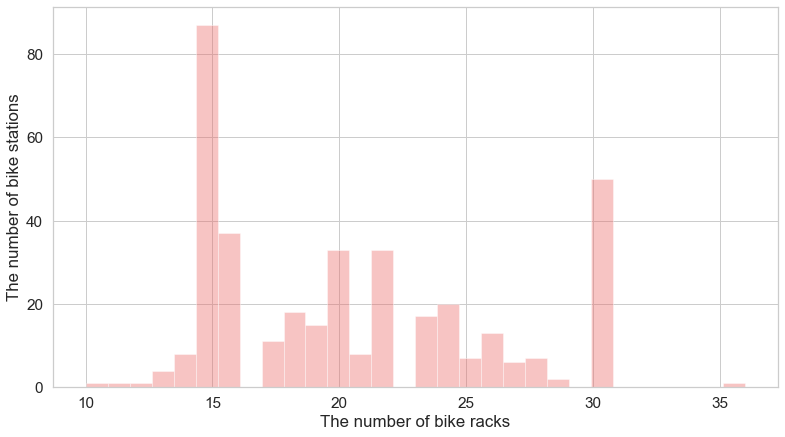

In [118]:
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.distplot(bikes_station_df_['bike_racks'], kde = False, bins = 30, color = '#eb6c6a').set(title = '', xlabel = 'The number of bike racks', ylabel = 'The number of bike stations')
plt.show()

In [119]:
bikes_station_df_['bike_racks'].value_counts()

15    87
30    50
16    37
22    33
20    33
24    20
18    18
23    17
19    15
26    13
17    11
14     8
21     8
25     7
28     7
27     6
13     4
29     2
10     1
36     1
12     1
11     1
Name: bike_racks, dtype: int64

In [120]:
bikes_station_df_.sort_values(by=['bike_racks'], na_position = 'first', ascending=False).reset_index(drop = True)

,name,lat,lng,bike_racks
0,Arkadia,52.255739915161,20.984342694283,36
1,Marszałkowska - Złota,52.244228827289,21.001626849174,30
2,Marszałkowska - al. Solidarności,52.2442666,21.0015893,30
3,Emilii Plater - Al. Jerozolimskie,52.2290464,21.0054544,30
4,Bulwar – most Śląsko – Dąbrowski,52.24788445501,21.019468903542,30
...,...,...,...,...
375,Obozowa - Radziwie,52.246037,20.962463,13
376,Stawki - Dubois,52.2535305,20.9924922,13
377,Plac Zbawiciela,52.2197681,21.0172775,12
378,Spektrum Tower,52.2343903,20.9991593,11


In [121]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from bokeh.io import output_notebook
import folium
import networkx as nx
from folium.plugins import MarkerCluster

In [122]:
output_notebook()

Loading BokehJS ...

In [123]:
output_file("gmapa.html")

map_options = GMapOptions(lat=52.2, lng=21, map_type="roadmap", zoom=11)

"""
For GMap to work, Google requires that you obtain and enable an API key from:

https://developers.google.com/maps/documentation/javascript/get-api-key

Change the API key below into your personal one
"""
p = gmap("API-key", map_options, title="Warsaw")

source = ColumnDataSource(
    data=dict(
        lat=bikes_station_df_.lat.tolist(),
        lon=bikes_station_df_.lng.tolist()
    )
)
p.circle(x="lon", y="lat", size=8, fill_color="blue", fill_alpha=0.8, source=source)

# displays the map of Warsaw with the location of 380 bicycle stations
show(p)

### 3.4. Interactive grouping of bikes stations using the Folium library

In [124]:
bikes_station_df_['lat'] = pd.to_numeric(bikes_station_df_['lat'])
bikes_station_df_['lng'] = pd.to_numeric(bikes_station_df_['lng'])

In [125]:
my_map = folium.Map(location=[52.24, 21.00],
    zoom_start=14,)

marker_cluster = MarkerCluster().add_to(my_map)
for ind in bikes_station_df_.index:     
    tooltip_txt = bikes_station_df_['name'][ind] + '<br>The number of bike racks: ' + str(bikes_station_df_['bike_racks'][ind])
    
     
    folium.Marker([float(bikes_station_df_['lat'][ind]), float(bikes_station_df_['lng'][ind])],
                  icon=folium.Icon(color='red'),
                  tooltip= tooltip_txt).add_to(my_map).add_to(marker_cluster)
my_map

### 3.5. Analysis of bike rentals

In [129]:
 bikes_df

temperature  rainfall  bike_rental
name                         date_                                         
1 Sierpnia - DK Włochy       2018-03-04         -6.7       0.0          4.0
                             2018-03-05         -1.6       0.0          3.0
                             2018-03-06          1.3       0.8         12.0
                             2018-03-07          2.1       0.2          5.0
                             2018-03-08          4.7       0.0          9.0
...                                              ...       ...          ...
Żwirki i Wigury - Racławicka 2018-03-28          1.8       0.0         32.0
                             2018-03-29          2.4       5.5         24.0
                             2018-03-30          6.4       0.0         31.0
                             2018-03-31          6.7       4.4         23.0
                             2018-04-01          5.0       4.3          7.0

[9976 rows x 3 columns]

In [63]:
rent_bikes = bikes_df.pivot_table(index='name', columns=['date_', 'temperature', 'rainfall'], values='bike_rental')

In [64]:
# the sum of bike rentals on individual days
total_rent = rent_bikes.copy()
total_ = total_rent.transpose()
total_["total"] = total_rent[0:].sum()
total_rent = total_.transpose()

In [65]:
# the sum of rented bikes on individual days 
tot_rent = rent_bikes.loc[rent_bikes.index!='name'].sum()
tot_rent.sort_values(ascending=False)

date_       temperature  rainfall
2018-03-25   4.2         0.0         10183.0
2018-03-11   9.4         0.0          9924.0
2018-03-26   4.5         0.0          8851.0
2018-03-13   10.5        0.0          8822.0
2018-03-12   10.4        0.0          8260.0
2018-03-30   6.4         0.0          7718.0
2018-03-10   4.7         0.0          7189.0
2018-03-28   1.8         0.0          7173.0
2018-03-24   3.2         0.0          7150.0
2018-03-27   1.6         0.1          6668.0
2018-03-14   5.9         0.3          6398.0
2018-03-22   1.4         0.0          6161.0
2018-03-23   1.8         0.0          6069.0
2018-03-15   0.6         0.0          5853.0
2018-03-21  -0.2         0.0          5573.0
2018-03-08   4.7         0.0          5573.0
2018-03-09   3.6         0.8          5475.0
2018-03-20  -1.1         0.0          5102.0
2018-03-19  -3.3         0.0          4393.0
2018-03-06   1.3         0.8          3725.0
2018-03-29   2.4         5.5          3699.0
2018-03-07   2.1     

In [66]:
rent_temp_df = pd.DataFrame(tot_rent)
rent_temp_df = rent_temp_df.reset_index()
rent_temp_df = rent_temp_df.rename(columns={0: "bikes_rental"})

In [67]:
rent_temp_df["date_"]

0     2018-03-04
1     2018-03-05
2     2018-03-06
3     2018-03-07
4     2018-03-08
5     2018-03-09
6     2018-03-10
7     2018-03-11
8     2018-03-12
9     2018-03-13
10    2018-03-14
11    2018-03-15
12    2018-03-16
13    2018-03-17
14    2018-03-18
15    2018-03-19
16    2018-03-20
17    2018-03-21
18    2018-03-22
19    2018-03-23
20    2018-03-24
21    2018-03-25
22    2018-03-26
23    2018-03-27
24    2018-03-28
25    2018-03-29
26    2018-03-30
27    2018-03-31
28    2018-04-01
Name: date_, dtype: object

In [68]:
rent_temp_df['date_'].loc[::2]

0     2018-03-04
2     2018-03-06
4     2018-03-08
6     2018-03-10
8     2018-03-12
10    2018-03-14
12    2018-03-16
14    2018-03-18
16    2018-03-20
18    2018-03-22
20    2018-03-24
22    2018-03-26
24    2018-03-28
26    2018-03-30
28    2018-04-01
Name: date_, dtype: object

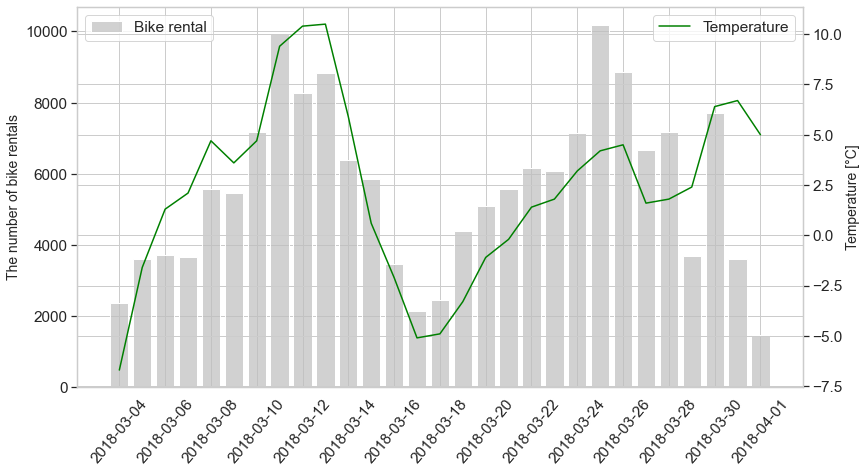

In [69]:
fig, ax = plt.subplots(figsize=(13,7))
ax2 = ax.twinx()
ax.bar(rent_temp_df["date_"], rent_temp_df["bikes_rental"], color=(190/255,190/255,190/255,0.7), label='Bike rental')
ax2.plot(rent_temp_df["date_"], rent_temp_df["temperature"], color='green', label='Temperature')
ax.set_ylabel("The number of bike rentals", fontsize='14')
ax2.set_ylabel("Temperature [°C]", fontsize='14')
ax.set_xticks(rent_temp_df['date_'].loc[::2])
ax.tick_params(axis='x', rotation=50)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('chart1.png', dpi=800)
plt.show()


In [70]:
warsaw_bikes_rent = warsaw_bikes_rent.rename(columns={"_date": "hour"})

In [75]:
hourly_rent = warsaw_bikes_rent.set_index('name').groupby([ 'name', 'hour', 'the_day_of_the_week']).agg({'temperature':np.mean, 'bike_rental':np.sum})
hourly_rent_ = hourly_rent.pivot_table(index='name', columns=['hour', 'temperature', 'the_day_of_the_week'], values='bike_rental') 


In [76]:
tot_hourly_rent = hourly_rent_.loc[df_ac.index!='name'].sum() # sum of bikes rented in each hour of each day of the analyzed period
rent_hourly_df = pd.DataFrame(tot_hourly_rent)
rent_hourly_df = rent_hourly_df.reset_index()
rent_hourly_df = rent_hourly_df.rename(columns={0: "bike_rental"})

In [77]:
rent_hourly_df

,hour,temperature,the_day_of_the_week,bike_rental
0,2018-03-04 00:00:00,-11.850000,Sunday,35.0
1,2018-03-04 01:00:00,-11.783333,Sunday,45.0
2,2018-03-04 02:00:00,-12.116667,Sunday,33.0
3,2018-03-04 03:00:00,-12.666667,Sunday,49.0
4,2018-03-04 04:00:00,-12.933333,Sunday,20.0
...,...,...,...,...
690,2018-04-01 19:00:00,2.716667,Sunday,93.0
691,2018-04-01 20:00:00,2.350000,Sunday,104.0
692,2018-04-01 21:00:00,1.683333,Sunday,100.0
693,2018-04-01 22:00:00,1.400000,Sunday,80.0


In [85]:
cats = ["Monday", 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rent_hourly_df['the_day_of_the_week'] = pd.Categorical(rent_hourly_df['the_day_of_the_week'], categories=cats, ordered=True)

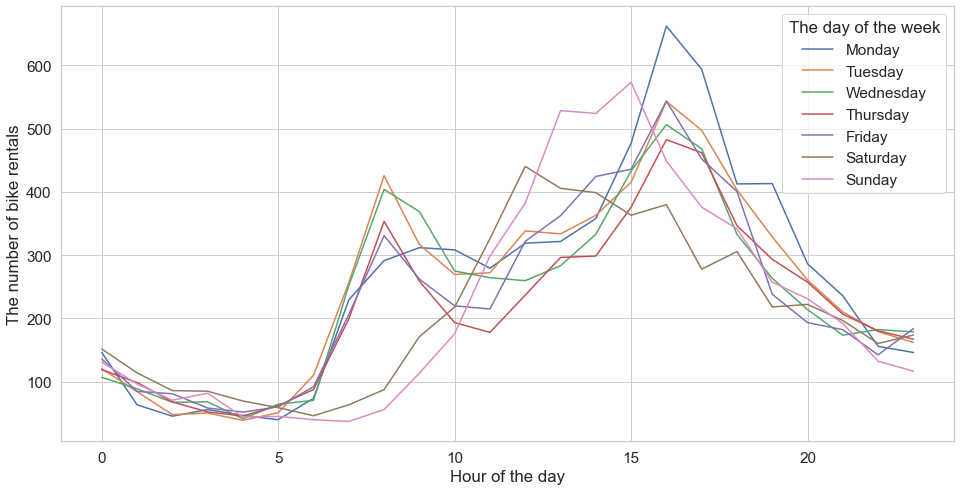

In [90]:
hourly_weekday_rent = rent_hourly_df.pivot_table(index=rent_hourly_df['hour'].dt.hour, 
                     columns='the_day_of_the_week', 
                     values='bike_rental', 
                     aggfunc='mean')
hourly_weekday_rent.plot(figsize=(16,8)).set(title = "", ylabel = 'The number of bike rentals', xlabel = 'Hour of the day')
plt.legend(title='The day of the week')
plt.savefig('chart2.png', dpi=800)
plt.show()

In [87]:
# table with the average bike rentals for individual days of the week and hours
hourly_weekday_rent.style.background_gradient(cmap='coolwarm', axis=None)
hourly_weekday_rent.style.background_gradient(cmap='coolwarm').set_precision(0)

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


the_day_of_the_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,146,121,107,119,136,152,131
1,64,84,89,99,85,114,97
2,46,48,68,68,81,86,71
3,56,50,68,52,58,85,82
4,47,39,42,46,52,70,44
5,40,51,64,62,60,59,45
6,74,110,70,88,92,46,40
7,230,256,252,199,206,64,37
8,292,426,404,354,331,88,56


In [82]:
temp_cor = rent_temp_df.drop(rent_temp_df.columns[[0]], axis = 1)

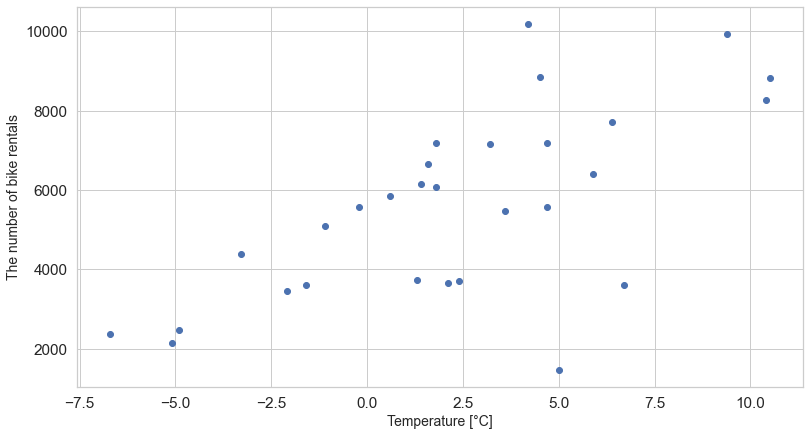

In [83]:
plt.figure(figsize=(13,7))
plt.plot("temperature", "bikes_rental", data=temp_cor, linestyle='none', marker='o')
plt.xlabel('Temperature [°C]', fontsize='14', 
           horizontalalignment='center')
plt.ylabel('The number of bike rentals', fontsize='14', 
           horizontalalignment='center')
#plt.title('The number of bike rentals vs. Temperature')
plt.savefig('plot1.png', dpi=800)
plt.show()

In [84]:
rain_temp_cor = rent_temp_df.corr() # table of correlation between variables
rain_temp_cor.style.background_gradient(cmap='coolwarm', axis=None)
rain_temp_cor.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,temperature,rainfall,bikes_rental
temperature,1.00,0.17,0.67
rainfall,0.17,1.00,-0.41
bikes_rental,0.67,-0.41,1.00


In [ ]:
plt.figure(figsize=(13,7))
plt.plot("temperature", "bikes_rental", data=rent_hourly_df, linestyle='none', marker='o')
plt.xlabel('Temperature [°C]', fontsize='14', 
           horizontalalignment='center')
plt.ylabel('The number of bike rentals', fontsize='14', 
           horizontalalignment='center')
#plt.title('The number of bike rentals vs. Temperature per hour')
plt.savefig('plot2.png', dpi=800)
plt.show()

### 3.5. Analysis of popularity of bike stations

In [ ]:
sort_rent_df = rent_bikes.transpose()
sort_rent_df = sort_rent_df.reset_index().rename_axis(None, axis=1)

In [ ]:
sort_rent_df = sort_rent_df.iloc[:, 3:]

In [ ]:
#sort stations by highest median bike rentals of the day
meds = sort_rent_df.median().sort_values(ascending=True)
sort_rent_df = sort_rent_df[meds.index]


In [ ]:
sort_rent_df.iloc[:, 334:345].boxplot(vert=False, figsize=(7,6))
#plt.savefig('filename.png', dpi=600)
plt.show()

In [ ]:
meds.sort_values(ascending = False).head(8)

In [ ]:
# extract from the dataset information about stations that have "Metro" in the name of the station
metro_bs_df = bikes_df.reset_index()
metro_bs_df = metro_bs_df[metro_bs_df.name.str.contains("Metro")]
metro_df = metro_bs_df.pivot_table(index='name', columns=['date_', 'temperature', 'rainfall'], values='bikes_rental')
sort_rent_ = metro_df.transpose()
sort_rent_ = sort_rent_.reset_index().rename_axis(None, axis=1)
sort_rent_ = sort_rent_.iloc[:, 3:]

In [ ]:
# the most popular bike stations on individual days of the week
df_week = warsaw_bikes_rent.groupby(['date_', 'name']).bikes_rental.sum().reset_index()
df_week = df_week.rename(columns = {"date_": "day_of_week"})
df_week = df_week.groupby([pd.to_datetime(df_week['day_of_week']).dt.dayofweek ,'name'])['bikes_rental'].median()
df_week.loc[df_week.groupby(level=0).idxmax()]

# sorting bike stations by the subway from the highest median of rentals
meds_metro = sort_rent_.median().sort_values(ascending=True)
sort_rent_ = sort_rent_[meds_metro.index]
# sort_rent_.boxplot(vert=False, figsize=(10,18))
# plt.show()

In [ ]:
# the most popular bike stations at specific times
df_hourly = warsaw_bikes_rent.groupby(['hour', 'name']).bikes_rental.sum().reset_index()
df_hourly = df_hourly.groupby([pd.to_datetime(df_hourly['hour']).dt.hour, 'name'])['bikes_rental'].median()
df_hourly.loc[df_hourly.groupby(level=0).idxmax()]

In [ ]:
# the most popular bike stations on individual days of the week
df_week = warsaw_bikes_rent.groupby(['date_', 'name']).bikes_rental.sum().reset_index()
df_week = df_week.rename(columns = {"date_": "day_of_week"})
df_week = df_week.groupby([pd.to_datetime(df_week['day_of_week']).dt.dayofweek ,'name'])['bikes_rental'].median()
df_week.loc[df_week.groupby(level=0).idxmax()]

In [ ]:
pop_hourly = pd.DataFrame(df_hourly)
most_pop_hourly = pop_hourly['bikes_rental'].groupby(level=0, group_keys=False)
most_pop_hourly.nlargest(2) # 2 most popular stations every hour

In [ ]:
bikes_station = pd.DataFrame(meds).reset_index()
bikes_station= bikes_station.rename(columns={"index": "name", 0: "median"})

In [ ]:
bikes_station_warsaw = pd.merge(bikes_station, bikes_station_df_, how = 'left', on = ['name'])